<a href="https://colab.research.google.com/github/devangi2000/Natural_Language_Processing/blob/master/RoBERTa_Fine_Tuning_Emotion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Emotion Classification using Fine-tuned BERT model

In this tutorial, I will show to fine-tune a language model (LM) for emotion classification with code adapted from this [tutorial](https://zablo.net/blog/post/custom-classifier-on-bert-model-guide-polemo2-sentiment-analysis/) by MARCIN ZABŁOCKI. I adapted his tutorial and modified the code to suit the emotion classification task using a different BERT model. Please refer to his tutorial for more detailed explanations for each code block. I really liked his tutorial because of the attention to detail and the use of high-level libraries to take care of certain parts of the model such as training and finding a good learning rate. 

Before you get started, make sure to enable `GPU` in the runtime and be sure to 
restart the runtime in this environment after installing the `pytorch-lr-finder` library.

This tutorial is in a rough draft so if you find any issues with this tutorial or have any further questions reach out to me via [Twitter](https://twitter.com/omarsar0).


In [1]:
%%capture
!pip install transformers tokenizers pytorch-lightning

In [2]:
## Note need to Restart runtime after running this code segment
%%capture
!git clone https://github.com/davidtvs/pytorch-lr-finder.git && cd pytorch-lr-finder && python setup.py install

In [3]:
import torch
from torch import nn
from typing import List
import torch.nn.functional as F
from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import logging
import os
from functools import lru_cache
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from argparse import Namespace
from sklearn.metrics import classification_report
torch.__version__

'1.7.0+cu101'

## Load the Pretrained Language Model
We are first going to look at pretrained language model provided by HuggingFace models. We will use a variant of BERT, called DistilRoBERTa base. The `base` model has less parameters than the `larger` model. 

[RoBERTa](https://arxiv.org/abs/1907.11692) is a variant of of BERT which "*modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates*".

Knowledge distillation help to train smaller LMs with similar performance and potential.

First, let's load the tokenizer for this model:

In [4]:
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')

Now let's load the actual model with the LM head that takes care of the prediciton for the LM. When fine-tuning we don't use the head and instead use the base model. The code below shows how to do this:

In [5]:
model = AutoModelWithLMHead.from_pretrained("distilroberta-base")
base_model = model.base_model

/usr/local/lib/python3.6/dist-packages/transformers/models/auto/modeling_auto.py:852: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Let's now try out the tokenizer first:

In [6]:
text = "Elvis is the king of rock!"
enc = tokenizer.encode_plus(text)
enc.keys()

dict_keys(['input_ids', 'attention_mask'])

In [7]:
print(enc)

{'input_ids': [0, 9682, 9578, 16, 5, 8453, 9, 3152, 328, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


`input_ids` are the numerical encoding of the tokens in the vocabulary. `attention_mask` is an addition option used when batching sequences together and you want to tell the model which tokens should be attented to ([read more](https://huggingface.co/transformers/glossary.html#attention-mask)). The attention mask information helps when dealing with variance in the size of sequences and we need a way to tell the model that we don't want to attend to the padded indices of the sequence.

We are only using `input_ids` and `attention_mask`

We need to also unsqueeze to simulate batch processing

Using DistilBertForSequenceClassification: https://huggingface.co/transformers/model_doc/distilbert.html#distilbertforsequenceclassification

In [8]:
out = base_model(torch.tensor(enc["input_ids"]).unsqueeze(0), torch.tensor(enc["attention_mask"]).unsqueeze(0))
out[0].shape

torch.Size([1, 10, 768])

In [9]:
## size of representation of one of the tokens 
out[0][:,0,:].shape

torch.Size([1, 768])

`torch.Size([1, 768])` represents batch_size, number of tokens in input text (lenght of tokenized text), model's output hidden size.

In [10]:
t = "Elvis is the king of rock"
enc = tokenizer.encode_plus(t)
token_representations = base_model(torch.tensor(enc["input_ids"]).unsqueeze(0))[0][0]
print(enc["input_ids"])
print(tokenizer.decode(enc["input_ids"]))
print(f"Length: {len(enc['input_ids'])}")
print(token_representations.shape)

[0, 9682, 9578, 16, 5, 8453, 9, 3152, 2]
<s>Elvis is the king of rock</s>
Length: 9
torch.Size([9, 768])


## Building Custom Classification head on top of LM base model

Use Mish activiation function as in the one proposed in the original tutorial

In [11]:
# from https://github.com/digantamisra98/Mish/blob/b5f006660ac0b4c46e2c6958ad0301d7f9c59651/Mish/Torch/mish.py
@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))
  
class Mish(nn.Module):
    def forward(self, input):
        return mish(input)

The model we will use to do the fine-tuning

In [12]:
class EmoModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )
        
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)
        
        # maybe do some pooling / RNNs... go crazy here!
        
        # use the <s> representation
        return self.classifier(hidden_states[0][:, 0, :])

### Pretest the model with dummy text
We want to ensure that the model is returing the right information back.

In [13]:
classifier = EmoModel(AutoModelWithLMHead.from_pretrained("distilroberta-base").base_model, 3)

/usr/local/lib/python3.6/dist-packages/transformers/models/auto/modeling_auto.py:852: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,
Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
X = torch.tensor(enc["input_ids"]).unsqueeze(0).to('cpu')
attn = torch.tensor(enc["attention_mask"]).unsqueeze(0).to('cpu')

In [15]:
classifier((X, attn))

tensor([[ 0.0707, -0.0250, -0.0219]], grad_fn=<AddmmBackward>)

## Prepare your dataset for fine-tuning

In [16]:
!mkdir -p tokenizer

In [17]:
## load pretrained tokenizer information
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/added_tokens.json')

In [18]:
!ls tokenizer

merges.txt  special_tokens_map.json  tokenizer_config.json  vocab.json


Implement CollateFN using fast tokenizers.
This function basically takes care of proper tokenization and batches of sequences. This way you don't need to create your batches manually. Find out more about Tokenizers [here](https://github.com/huggingface/tokenizers/tree/master/bindings/python).

In [19]:
class TokenizersCollateFn:
    def __init__(self, max_tokens=512):

        ## RoBERTa uses BPE tokenizer similar to GPT
        t = ByteLevelBPETokenizer(
            "tokenizer/vocab.json",
            "tokenizer/merges.txt"
        )
        t._tokenizer.post_processor = BertProcessing(
            ("</s>", t.token_to_id("</s>")),
            ("<s>", t.token_to_id("<s>")),
        )
        t.enable_truncation(max_tokens)
        t.enable_padding(max_length=max_tokens, pad_id=t.token_to_id("<pad>"))
        self.tokenizer = t

    def __call__(self, batch):
        encoded = self.tokenizer.encode_batch([x[0] for x in batch])
        sequences_padded = torch.tensor([enc.ids for enc in encoded])
        attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
        labels = torch.tensor([x[1] for x in batch])
        
        return (sequences_padded, attention_masks_padded), labels

## Getting the Data and Preview it
Below we are going to load the data and show you how to create the splits. However, we don't need to split the data manually becuase I have already created the splits and stored those files seperately which you can quickly download below:

In [20]:
!wget https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
!wget https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
!wget https://www.dropbox.com/s/2mzialpsgf9k5l3/val.txt

--2020-12-01 18:13:01--  https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ikkqxfdbdec3fuj/test.txt [following]
--2020-12-01 18:13:01--  https://www.dropbox.com/s/raw/ikkqxfdbdec3fuj/test.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbe613a54dab51a7a7beb3260f4.dl.dropboxusercontent.com/cd/0/inline/BESDWGhKxLyPeDG-hZve9l8syq_HMAYL_nHe5oyc8fZXDYKT1kZ0ueGly3g8M7XPGKuRlRAIcTq5JDq2hWTABnOVtr_7BqYG_6d6VG87_ArWvCotLalCS2BrFvcA3qDETe0/file# [following]
--2020-12-01 18:13:01--  https://ucbe613a54dab51a7a7beb3260f4.dl.dropboxusercontent.com/cd/0/inline/BESDWGhKxLyPeDG-hZve9l8syq_HMAYL_nHe5oyc8fZXDYKT1kZ0ueGly3g8M7XPGKuRlRAIcTq5JDq2hWTABnOVtr_7BqYG_6d6VG87_ArWvCotLalCS2BrFvcA3q

In [21]:
## export the datasets as txt files
## EXERCISE: Change this to an address

train_path = "train.txt"
test_path = "test.txt"
val_path = "val.txt"

## emotion labels
label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}

In [22]:
!wget https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl

--2020-12-01 18:15:11--  https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/607ptdakxuh5i4s/merged_training.pkl [following]
--2020-12-01 18:15:12--  https://www.dropbox.com/s/raw/607ptdakxuh5i4s/merged_training.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce4af1a6618f66d8dfa67b04f05.dl.dropboxusercontent.com/cd/0/inline/BESUSI2qCyN0_-ZKDfpw2CGoDgaVKXZnyEP5ZsSHRlEBZ7BAQHcYFu7Q1fa4bsqLo1JzT6fF8mlaep88iFgEy-JKM2RHfA3-aJmepD8Ea3YNWdKpkeqofrmIwDi-FRU8b78/file# [following]
--2020-12-01 18:15:12--  https://uce4af1a6618f66d8dfa67b04f05.dl.dropboxusercontent.com/cd/0/inline/BESUSI2qCyN0_-ZKDfpw2CGoDgaVKXZnyEP5ZsSHRlEBZ7BAQHcYFu7Q1fa4bsqLo1JzT6fF8mlaep88iFgEy-JKM2RHf

In [23]:
import pickle

## helper function
def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

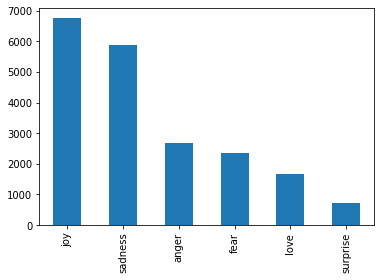

In [24]:
data = load_from_pickle(directory="merged_training.pkl")

## using a sample
emotions = [ "sadness", "joy", "love", "anger", "fear", "surprise"]
data= data[data["emotions"].isin(emotions)]


data = data.sample(n=20000);

data.emotions.value_counts().plot.bar()

In [25]:
data.count()

text        20000
emotions    20000
dtype: int64

Data has been preprocessed already, using technique from this paper: https://www.aclweb.org/anthology/D18-1404/

In [26]:
data.head()

,text,emotions
87205,i remember feeling so isolated staying in euro...,sadness
52616,im feeling aggravated with the end result of t...,anger
16504,i feel encaged by my petty life,anger
18971,i could feel sleep calling and i was so thrill...,joy
110871,im feelin discontent this is what im listening...,sadness


In [27]:
## reset index
data.reset_index(drop=True, inplace=True)

In [28]:
## check unique emotions in the dataset
data.emotions.unique()

array(['sadness', 'anger', 'joy', 'love', 'surprise', 'fear'],
      dtype=object)

## Split the data and store into individual text files

In [29]:
## uncomment the code below to generate the text files for your train, val, and test datasets.

'''
from sklearn.model_selection import train_test_split
import numpy as np

# Creating training and validation sets using an 80-20 split
input_train, input_val, target_train, target_val = train_test_split(data.text.to_numpy(), 
                                                                    data.emotions.to_numpy(), 
                                                                    test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_val, input_test, target_val, target_test = train_test_split(input_val, target_val, test_size=0.5)


## create a dataframe for each dataset
train_dataset = pd.DataFrame(data={"text": input_train, "class": target_train})
val_dataset = pd.DataFrame(data={"text": input_val, "class": target_val})
test_dataset = pd.DataFrame(data={"text": input_test, "class": target_test})
final_dataset = {"train": train_dataset, "val": val_dataset , "test": test_dataset }

train_dataset.to_csv(train_path, sep=";",header=False, index=False)
val_dataset.to_csv(test_path, sep=";",header=False, index=False)
test_dataset.to_csv(val_path, sep=";",header=False, index=False)
'''

'\nfrom sklearn.model_selection import train_test_split\nimport numpy as np\n\n# Creating training and validation sets using an 80-20 split\ninput_train, input_val, target_train, target_val = train_test_split(data.text.to_numpy(), \n                                                                    data.emotions.to_numpy(), \n                                                                    test_size=0.2)\n\n# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50\ninput_val, input_test, target_val, target_test = train_test_split(input_val, target_val, test_size=0.5)\n\n\n## create a dataframe for each dataset\ntrain_dataset = pd.DataFrame(data={"text": input_train, "class": target_train})\nval_dataset = pd.DataFrame(data={"text": input_val, "class": target_val})\ntest_dataset = pd.DataFrame(data={"text": input_test, "class": target_test})\nfinal_dataset = {"train": train_dataset, "val": val_dataset , "test": test_dataset }\n\ntrain_dataset.to_csv(tra

## Create the Dataset object

Create the Dataset object that will be used to load the different datasets.

In [30]:
class EmoDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.data_column = "text"
        self.class_column = "class"
        self.data = pd.read_csv(path, sep=";", header=None, names=[self.data_column, self.class_column],
                               engine="python")

    def __getitem__(self, idx):
        return self.data.loc[idx, self.data_column], label2int[self.data.loc[idx, self.class_column]]

    def __len__(self):
        return self.data.shape[0]

Sanity check

In [31]:
ds = EmoDataset(train_path)
ds[19]

('i now feel compromised and skeptical of the value of every unit of work i put in',
 4)

## Training with PyTorchLightning

PyTorchLightning is just a library that abstracts the complexity of training neural networks with PyTorch. It is built on top of PyTorch and simplifies training.

![](https://pytorch-lightning.readthedocs.io/en/latest/_images/pt_to_pl.png)

In [32]:
## Methods required by PyTorchLightning

class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = EmoModel(AutoModelWithLMHead.from_pretrained("distilroberta-base").base_model, len(emotions))
        self.loss = nn.CrossEntropyLoss() ## combines LogSoftmax() and NLLLoss()
        self.hparams = hparams

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmoDataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    shuffle=shuffle,
                    collate_fn=TokenizersCollateFn()
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        ## use AdamW optimizer -- faster approach to training NNs
        ## read: https://www.fast.ai/2018/07/02/adam-weight-decay/
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr)
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

## Finding Learning rate for the model

The code below aims to obtain valuable information about the optimal learning rate during a pretraining run. Determine boundary and increase the leanring rate linearly or exponentially.

More: https://github.com/davidtvs/pytorch-lr-finder

In [34]:
!pip install torch_lr_finder

In [41]:
lr=0.1 ## uper bound LR
#from torch_lr_finder import LRFinder
hparams_tmp = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=1,
    lr=lr,
    accumulate_grad_batches=1,
)
module = TrainingModule(hparams_tmp)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(module.parameters(), lr=5e-7) ## lower bound LR
lr_finder = torch_lr_finder.LRFinder(module, optimizer, criterion, device="cuda")
lr_finder.range_test(module.train_dataloader(), end_lr=100, num_iter=100, accumulation_steps=hparams_tmp.accumulate_grad_batches)
lr_finder.plot()
lr_finder.reset()

/usr/local/lib/python3.6/dist-packages/transformers/models/auto/modeling_auto.py:852: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,
Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: ignored

In [36]:
lr = 1e-4 
lr

0.0001

In [37]:
lr_finder.plot(show_lr=lr)

NameError: ignored

## Training the Emotion Classifier

In [ ]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=32,
    warmup_steps=100,
    epochs=1,
    lr=lr,
    accumulate_grad_batches=1
)
module = TrainingModule(hparams)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-config.json from cache at /root/.cache/torch/transformers/d52ced8fd31ba6aa311b6eeeae65178cca00ddd6333c087be4601dc46c20bd96.deeb956b92b63ef883f183df980353df2c982e37e78a00189cf9146088df28dd
INFO:transformers.configuration_utils:Model config RobertaConfig {
  "_num_labels": 2,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": 0,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps"

In [ ]:
## garbage collection
import gc; gc.collect()
torch.cuda.empty_cache()

In [ ]:
## train roughly for about 10-15 minutes with GPU enabled.
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs, progress_bar_refresh_rate=10,
                     accumulate_grad_batches=hparams.accumulate_grad_batches)

trainer.fit(module)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/warnings.py:18: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/warnings.py:18: RuntimeWarning: You have defined a `test_dataloader()` and have defined a `test_step()`, you may also want to define `test_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
INFO:lightning:
    | Name                                                        | Type              | Params
----------------------------------------------------------------------------------------------
0   | model                                                       | EmoModel          | 82 M  
1   | model.base_model                                    

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/warnings.py:18: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

In [ ]:
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        batch = (X.cuda(), attn.cuda())
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module(batch), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=len(emotions)))


________________________________________________________________________________
              precision    recall  f1-score   support

     sadness   0.961872  0.955250  0.958549       581
         joy   0.958580  0.932374  0.945295       695
        love   0.806818  0.893082  0.847761       159
       anger   0.936567  0.912727  0.924494       275
        fear   0.886364  0.870536  0.878378       224
    surprise   0.674699  0.848485  0.751678        66

    accuracy                       0.923500      2000
   macro avg   0.870817  0.902076  0.884359      2000
weighted avg   0.926988  0.923500  0.924647      2000

